In [1]:
#!pip install tensorflow-federated

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

# Helper: Create CNN model
def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Helper: Create IID and non-IID datasets
def create_datasets(iid=True, num_clients=10):
    mnist_data = tf.keras.datasets.mnist.load_data()
    (train_data, train_labels), _ = mnist_data

    # Normalize and reshape data
    train_data = train_data.astype('float32') / 255.0
    train_data = train_data.reshape(-1, 28, 28, 1)

    # Shuffle and split data among clients
    if iid:
        indices = np.arange(len(train_data))
        np.random.shuffle(indices)
        shards = np.array_split(indices, num_clients)
    else:
        # Non-IID: Separate by digit labels, ensure at least 1 section
        shards = []
        for i in range(10):  # 10 digit classes
            class_indices = np.where(train_labels == i)[0]
            np.random.shuffle(class_indices)
            sections = max(1, num_clients // 10)
            shards.extend(np.array_split(class_indices, sections))

    clients_data = [
        (train_data[shard], train_labels[shard]) for shard in shards[:num_clients]
    ]
    return clients_data

# Additional attack methods
def apply_attack(dataset, attack_type):
    data, labels = dataset
    def modify_data(x, y):
        if attack_type == "label_flip":
            y = (y + 1) % 10  # Flip labels
        elif attack_type == "noise":
            x = x + tf.random.normal(shape=tf.shape(x), mean=0, stddev=0.1)  # Add noise to inputs
        elif attack_type == "model_poisoning":
            x = x * 2  # Arbitrary manipulation
        elif attack_type == "data_duplication":
            x = tf.concat([x, x], axis=0)
            y = tf.concat([y, y], axis=0)
        elif attack_type == "random_data":
            y = tf.random.uniform(shape=tf.shape(y), maxval=10, dtype=tf.int32)
        return x, y
    return data, labels

# Aggregation functions
def mean_aggregation(client_weights):
    return np.mean(client_weights, axis=0)

def krum_aggregation(client_weights, f=1):
    # Implementing Krum aggregation
    n = len(client_weights)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distances[i, j] = distances[j, i] = np.linalg.norm(client_weights[i] - client_weights[j])
    scores = [np.sum(np.sort(distances[i])[1:(n - f - 1)]) for i in range(n)]
    selected_idx = np.argmin(scores)
    return client_weights[selected_idx]



def trimmed_mean_aggregation(updates, trim_ratio=0.2):
    num_clients = len(updates)
    lower_idx = int(trim_ratio * num_clients)
    upper_idx = num_clients - lower_idx

    def trimmed_mean(grads):
        # Convert to Tensor
        grads = tf.stack(grads)

        # Perform partial sorting to extract the trimmed range
        top_k = tf.nn.top_k(-grads, k=num_clients - lower_idx)  # Largest values (negative for ascending order)
        bottom_k = tf.nn.top_k(grads, k=num_clients - upper_idx)  # Smallest values
        trimmed_grads = tf.concat([bottom_k.values, -top_k.values], axis=0)

        # Compute the mean of the trimmed gradients
        return tf.reduce_mean(trimmed_grads, axis=0)

    # Apply trimmed mean for each gradient across updates
    return [trimmed_mean(grads) for grads in zip(*updates)]


def median_aggregation(weights):
    """Compute the median of the weights across clients."""
    flat_weights = [flatten_weights(client_weights) for client_weights in weights]
    median_weights = np.median(flat_weights, axis=0)  # Calculate median along the client axis
    return median_weights

# Federated averaging is equivalent to mean aggregation
federated_averaging = mean_aggregation


# Simplified Bulyan aggregation
def bulyan_aggregation(updates, num_malicious=0):
    selected_updates = [krum_aggregation(updates, num_malicious)]
    return mean_aggregation(selected_updates)

# Optimized differential privacy aggregation
def dp_aggregation(updates, noise_scale=0.1):
    mean_updates = mean_aggregation(updates)
    return [grad + tf.random.normal(shape=grad.shape, stddev=noise_scale) for grad in mean_updates]


# Flatten weights
def flatten_weights(weights):
    flat_weights = []
    for layer_weights in weights:
        flat_weights.append(layer_weights.flatten())
    return np.concatenate(flat_weights)

def unflatten_weights(flat_weights, reference_weights):
    """Reconstruct the model's weights from the flat weight representation."""
    unflattened_weights = []
    idx = 0
    for layer_weights in reference_weights:
        size = np.prod(layer_weights.shape)
        # Convert to NumPy array before reshaping
        unflattened_weights.append(np.array(flat_weights[idx:idx + size]).reshape(layer_weights.shape))
        idx += size
    return unflattened_weights


# Federated training function
def train_federated(model_fn, clients, aggregation_fn, attack_type=None, malicious_clients=0, num_rounds=3):
    global_model = model_fn()
    global_weights = global_model.get_weights()
    results = []

    # Load test data only once, outside the training loop
    _, (test_data, test_labels) = tf.keras.datasets.mnist.load_data()
    test_data = test_data.astype('float32') / 255.0
    test_data = test_data.reshape(-1, 28, 28, 1)

    for round_num in range(num_rounds):
        client_weights = []

        # Training loop for each round
        for client_idx, (data, labels) in enumerate(clients):
            local_model = model_fn()
            local_model.set_weights(global_weights)

            # Apply attack if the client is malicious
            if client_idx < malicious_clients and attack_type:
                data, labels = apply_attack((data, labels), attack_type)

            # Train the local model
            local_model.fit(data, labels, epochs=1, batch_size=256, verbose=0)

            # Flatten weights and append to client_weights
            client_weights.append(flatten_weights(local_model.get_weights()))

        # Aggregating weights using the specified aggregation function
        aggregated_weights = aggregation_fn(client_weights)

        # Unflatten aggregated weights and update global model weights
        global_weights = unflatten_weights(aggregated_weights, global_weights)
        global_model.set_weights(global_weights)

        # Evaluate on the test dataset
        loss, accuracy = global_model.evaluate(test_data, test_labels, verbose=0)
        results.append(accuracy)
        print(f"Round {round_num + 1}: Accuracy = {accuracy:.4f}")

    return results



# Evaluation
def evaluate(model, datasets):
    correct, total = 0, 0
    for data, labels in datasets:
        predictions = model(data, training=False)
        correct += np.sum(np.argmax(predictions.numpy(), axis=1) == labels)
        total += labels.shape[0]
    return correct / total


ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.10/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


Round 1: Accuracy = 0.9173
Round 2: Accuracy = 0.9432
Round 3: Accuracy = 0.9594
Round 1: Accuracy = 0.9187
Round 2: Accuracy = 0.9469
Round 3: Accuracy = 0.9628
Round 1: Accuracy = 0.9119
Round 2: Accuracy = 0.9418
Round 3: Accuracy = 0.9573
Round 1: Accuracy = 0.1694
Round 2: Accuracy = 0.1726
Round 3: Accuracy = 0.1050
Round 1: Accuracy = 0.0995
Round 2: Accuracy = 0.1268
Round 3: Accuracy = 0.1030
Round 1: Accuracy = 0.0982
Round 2: Accuracy = 0.1028
Round 3: Accuracy = 0.1397


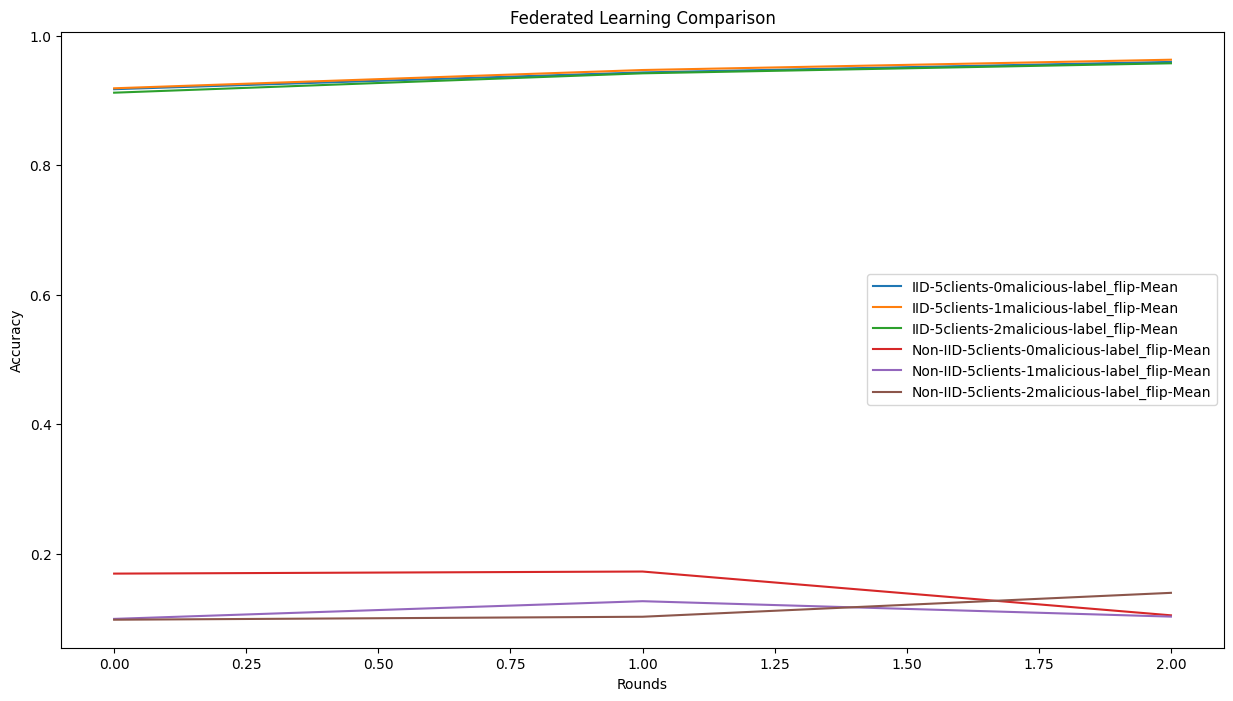

In [3]:

results = {}
# Main script
def main():
    num_clients_list = [5]
    num_malicious_list = [0,1,2]
    attack_types = ["label_flip"]
    #, "noise", "model_poisoning", "data_duplication", "random_data"]
    aggregation_methods = {
        "Mean": mean_aggregation,
        #"Median": median_aggregation,
        # "Trimmed Mean": trimmed_mean_aggregation,
        # "FedAvg": federated_averaging,
        # "Krum": krum_aggregation,
        # "Bulyan": bulyan_aggregation,
        # "DP": dp_aggregation
    }

    results = {}
    for iid in [True, False]:
        iid_label = "IID" if iid else "Non-IID"
        for num_clients in num_clients_list:
            for num_malicious in num_malicious_list:
                for attack in attack_types:
                    for method_name, aggregation_fn in aggregation_methods.items():
                        datasets = create_datasets(iid=iid, num_clients=num_clients)
                        accuracy = train_federated(create_cnn_model, datasets, aggregation_fn, attack, num_malicious)
                        key = f"{iid_label}-{num_clients}clients-{num_malicious}malicious-{attack}-{method_name}"
                        results[key] = accuracy

    # Plot results
    plt.figure(figsize=(15, 8))
    for key, accuracy in results.items():
        plt.plot(range(len(accuracy)), accuracy, label=key)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.title("Federated Learning Comparison")
    plt.show()
    return results

if __name__ == "__main__":
  resultfinal =  main()


In [4]:
import json
with open("results_label_flip_1.json", "w") as f:
    json.dump(resultfinal, f)

Round 1: Accuracy = 0.9202
Round 2: Accuracy = 0.9456
Round 3: Accuracy = 0.9593
Round 1: Accuracy = 0.9234
Round 2: Accuracy = 0.9449
Round 3: Accuracy = 0.9607
Round 1: Accuracy = 0.9237
Round 2: Accuracy = 0.9457
Round 3: Accuracy = 0.9601
Round 1: Accuracy = 0.1135
Round 2: Accuracy = 0.0980
Round 3: Accuracy = 0.0982
Round 1: Accuracy = 0.0939
Round 2: Accuracy = 0.1032
Round 3: Accuracy = 0.1135
Round 1: Accuracy = 0.1135
Round 2: Accuracy = 0.0982
Round 3: Accuracy = 0.0980


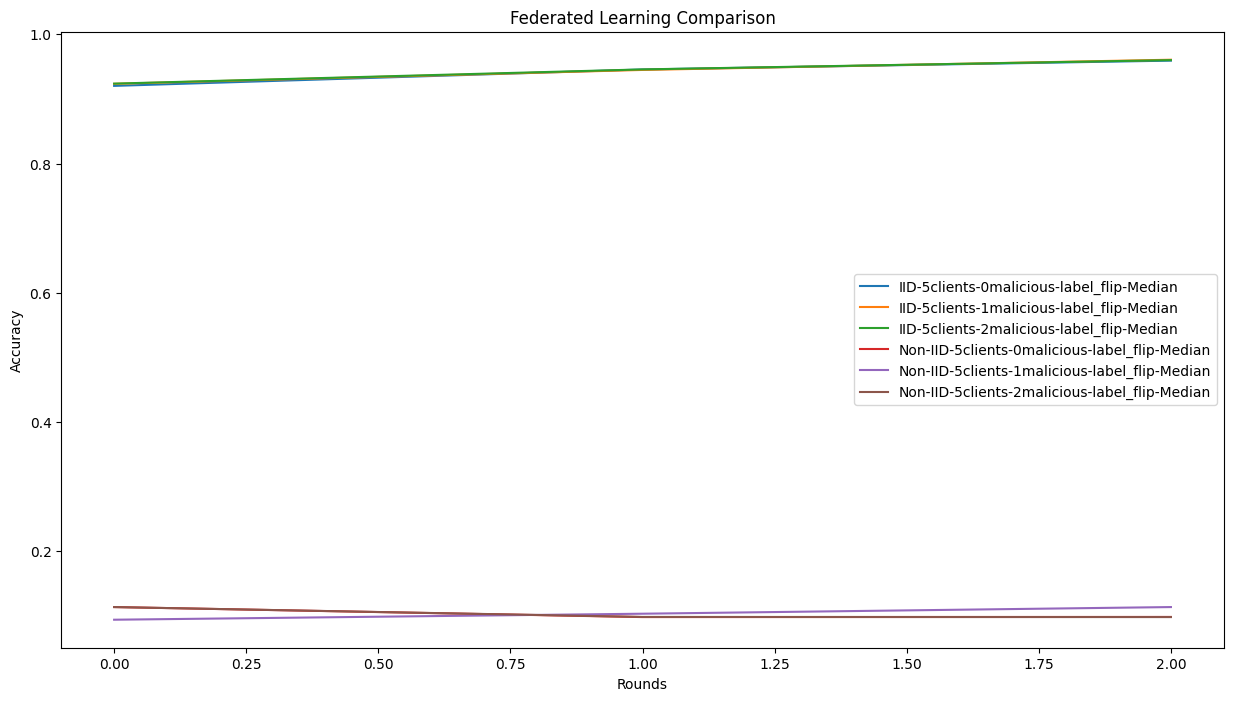

In [5]:

results = {}
# Main script
def main():
    num_clients_list = [5]
    num_malicious_list = [0,1,2]
    attack_types = ["label_flip"]
    #, "noise", "model_poisoning", "data_duplication", "random_data"]
    aggregation_methods = {
        #"Mean": mean_aggregation,
        "Median": median_aggregation,
        # "Trimmed Mean": trimmed_mean_aggregation,
        # "FedAvg": federated_averaging,
        # "Krum": krum_aggregation,
        # "Bulyan": bulyan_aggregation,
        # "DP": dp_aggregation
    }

    results = {}
    for iid in [True, False]:
        iid_label = "IID" if iid else "Non-IID"
        for num_clients in num_clients_list:
            for num_malicious in num_malicious_list:
                for attack in attack_types:
                    for method_name, aggregation_fn in aggregation_methods.items():
                        datasets = create_datasets(iid=iid, num_clients=num_clients)
                        accuracy = train_federated(create_cnn_model, datasets, aggregation_fn, attack, num_malicious)
                        key = f"{iid_label}-{num_clients}clients-{num_malicious}malicious-{attack}-{method_name}"
                        results[key] = accuracy

    # Plot results
    plt.figure(figsize=(15, 8))
    for key, accuracy in results.items():
        plt.plot(range(len(accuracy)), accuracy, label=key)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.title("Federated Learning Comparison")
    plt.show()
    return results

if __name__ == "__main__":
  resultfinal =  main()


In [6]:
import json
with open("results_label_flip_2.json", "w") as f:
    json.dump(resultfinal, f)

Round 1: Accuracy = 0.9184
Round 2: Accuracy = 0.9422
Round 3: Accuracy = 0.9535
Round 1: Accuracy = 0.9174
Round 2: Accuracy = 0.9429
Round 3: Accuracy = 0.9567
Round 1: Accuracy = 0.9093
Round 2: Accuracy = 0.9362
Round 3: Accuracy = 0.9513
Round 1: Accuracy = 0.0980
Round 2: Accuracy = 0.0980
Round 3: Accuracy = 0.0980
Round 1: Accuracy = 0.0980
Round 2: Accuracy = 0.0980
Round 3: Accuracy = 0.0980
Round 1: Accuracy = 0.0980
Round 2: Accuracy = 0.0980
Round 3: Accuracy = 0.0980


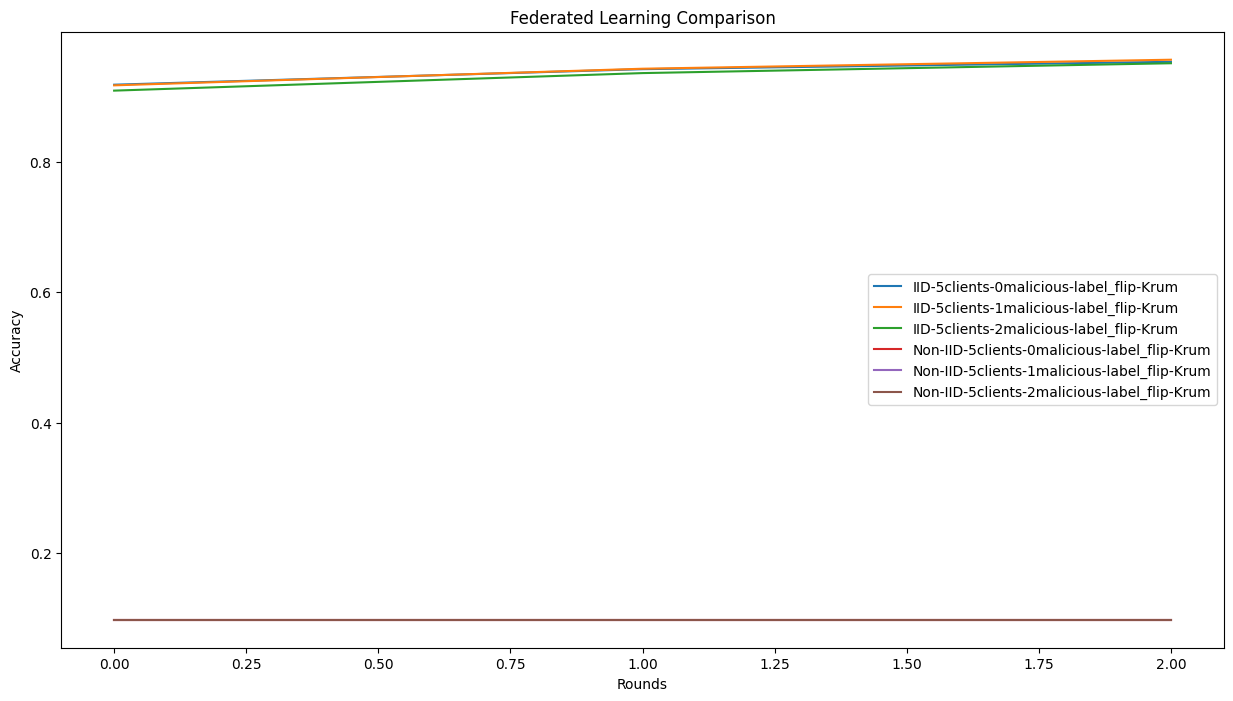

In [7]:

results = {}
# Main script
def main():
    num_clients_list = [5]
    num_malicious_list = [0,1,2]
    attack_types = ["label_flip"]
    #, "noise", "model_poisoning", "data_duplication", "random_data"]
    aggregation_methods = {
        #"Mean": mean_aggregation,
        #"Median": median_aggregation,
        # "Trimmed Mean": trimmed_mean_aggregation,
        # "FedAvg": federated_averaging,
         "Krum": krum_aggregation,
        # "Bulyan": bulyan_aggregation,
        # "DP": dp_aggregation
    }

    results = {}
    for iid in [True, False]:
        iid_label = "IID" if iid else "Non-IID"
        for num_clients in num_clients_list:
            for num_malicious in num_malicious_list:
                for attack in attack_types:
                    for method_name, aggregation_fn in aggregation_methods.items():
                        datasets = create_datasets(iid=iid, num_clients=num_clients)
                        accuracy = train_federated(create_cnn_model, datasets, aggregation_fn, attack, num_malicious)
                        key = f"{iid_label}-{num_clients}clients-{num_malicious}malicious-{attack}-{method_name}"
                        results[key] = accuracy

    # Plot results
    plt.figure(figsize=(15, 8))
    for key, accuracy in results.items():
        plt.plot(range(len(accuracy)), accuracy, label=key)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.title("Federated Learning Comparison")
    plt.show()
    return results

if __name__ == "__main__":
  resultfinal =  main()


In [8]:
import json
with open("results_label_flip_3.json", "w") as f:
    json.dump(resultfinal, f)

Round 1: Accuracy = 0.9174
Round 2: Accuracy = 0.9430
Round 3: Accuracy = 0.9577
Round 1: Accuracy = 0.9162
Round 2: Accuracy = 0.9420
Round 3: Accuracy = 0.9549
Round 1: Accuracy = 0.9223
Round 2: Accuracy = 0.9498
Round 3: Accuracy = 0.9621
Round 1: Accuracy = 0.1135
Round 2: Accuracy = 0.1022
Round 3: Accuracy = 0.1135
Round 1: Accuracy = 0.1860
Round 2: Accuracy = 0.1415
Round 3: Accuracy = 0.1958
Round 1: Accuracy = 0.1050
Round 2: Accuracy = 0.1139
Round 3: Accuracy = 0.1029


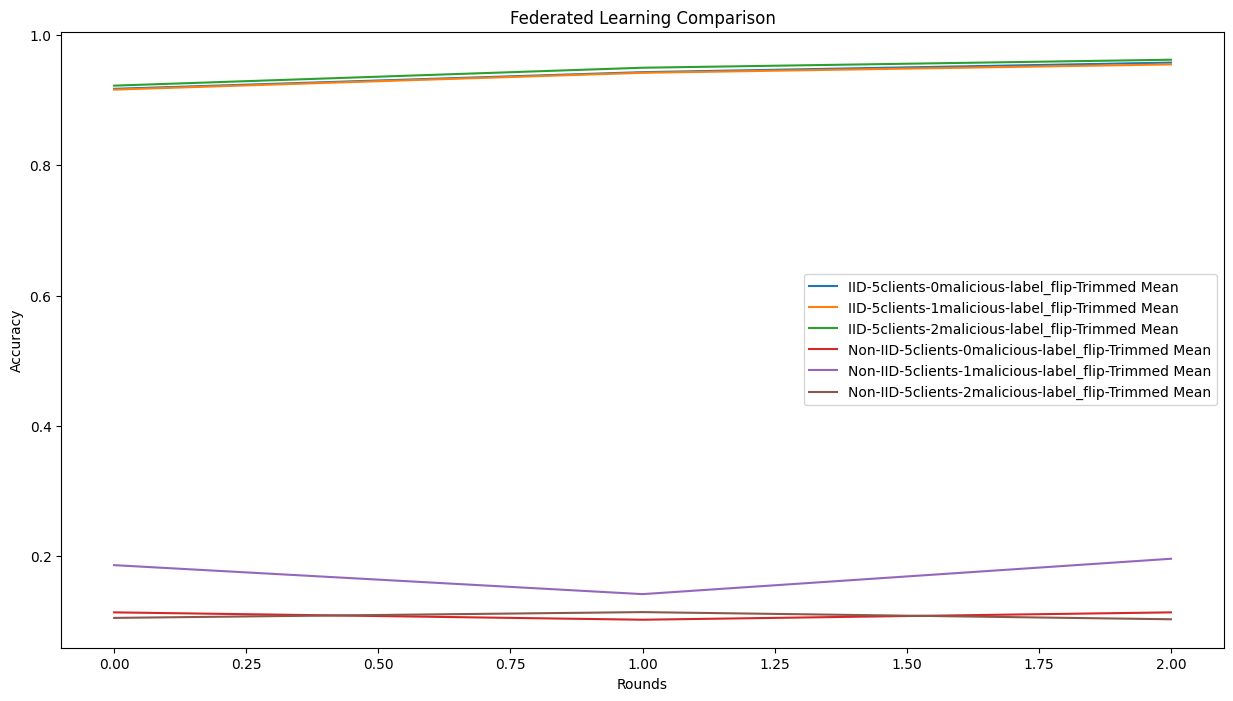

In [9]:

results = {}
# Main script
def main():
    num_clients_list = [5]
    num_malicious_list = [0,1,2]
    attack_types = ["label_flip"]
    #, "noise", "model_poisoning", "data_duplication", "random_data"]
    aggregation_methods = {
        #"Mean": mean_aggregation,
        #"Median": median_aggregation,
       "Trimmed Mean": trimmed_mean_aggregation,
        # "FedAvg": federated_averaging,
        # "Krum": krum_aggregation,
        # "Bulyan": bulyan_aggregation,
        # "DP": dp_aggregation
    }

    results = {}
    for iid in [True, False]:
        iid_label = "IID" if iid else "Non-IID"
        for num_clients in num_clients_list:
            for num_malicious in num_malicious_list:
                for attack in attack_types:
                    for method_name, aggregation_fn in aggregation_methods.items():
                        datasets = create_datasets(iid=iid, num_clients=num_clients)
                        accuracy = train_federated(create_cnn_model, datasets, aggregation_fn, attack, num_malicious)
                        key = f"{iid_label}-{num_clients}clients-{num_malicious}malicious-{attack}-{method_name}"
                        results[key] = accuracy

    # Plot results
    plt.figure(figsize=(15, 8))
    for key, accuracy in results.items():
        plt.plot(range(len(accuracy)), accuracy, label=key)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.title("Federated Learning Comparison")
    plt.show()
    return results

if __name__ == "__main__":
  resultfinal =  main()


In [10]:
import json
with open("results_label_flip_4.json", "w") as f:
    json.dump(resultfinal, f)

Round 1: Accuracy = 0.9153
Round 2: Accuracy = 0.9432
Round 3: Accuracy = 0.9572
Round 1: Accuracy = 0.9148
Round 2: Accuracy = 0.9383
Round 3: Accuracy = 0.9529
Round 1: Accuracy = 0.9116
Round 2: Accuracy = 0.9422
Round 3: Accuracy = 0.9577
Round 1: Accuracy = 0.1281
Round 2: Accuracy = 0.1028
Round 3: Accuracy = 0.1163
Round 1: Accuracy = 0.1144
Round 2: Accuracy = 0.0981
Round 3: Accuracy = 0.0982
Round 1: Accuracy = 0.1016
Round 2: Accuracy = 0.0812
Round 3: Accuracy = 0.1034


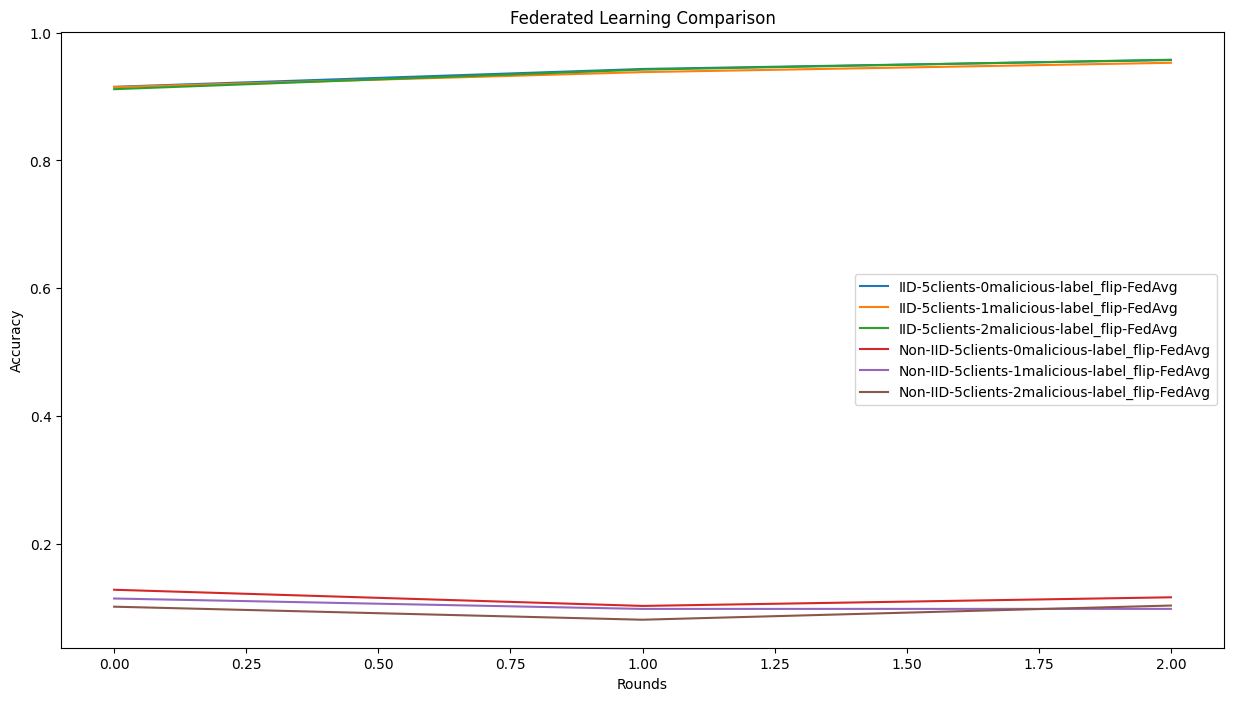

In [11]:

results = {}
# Main script
def main():
    num_clients_list = [5]
    num_malicious_list = [0,1,2]
    attack_types = ["label_flip"]
    #, "noise", "model_poisoning", "data_duplication", "random_data"]
    aggregation_methods = {
        #"Mean": mean_aggregation,
        #"Median": median_aggregation,
        # "Trimmed Mean": trimmed_mean_aggregation,
         "FedAvg": federated_averaging,
        # "Krum": krum_aggregation,
        # "Bulyan": bulyan_aggregation,
        # "DP": dp_aggregation
    }

    results = {}
    for iid in [True, False]:
        iid_label = "IID" if iid else "Non-IID"
        for num_clients in num_clients_list:
            for num_malicious in num_malicious_list:
                for attack in attack_types:
                    for method_name, aggregation_fn in aggregation_methods.items():
                        datasets = create_datasets(iid=iid, num_clients=num_clients)
                        accuracy = train_federated(create_cnn_model, datasets, aggregation_fn, attack, num_malicious)
                        key = f"{iid_label}-{num_clients}clients-{num_malicious}malicious-{attack}-{method_name}"
                        results[key] = accuracy

    # Plot results
    plt.figure(figsize=(15, 8))
    for key, accuracy in results.items():
        plt.plot(range(len(accuracy)), accuracy, label=key)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.title("Federated Learning Comparison")
    plt.show()
    return results

if __name__ == "__main__":
  resultfinal =  main()


In [12]:
import json
with open("results_label_flip_5.json", "w") as f:
    json.dump(resultfinal, f)

Round 1: Accuracy = 0.9143
Round 2: Accuracy = 0.9357
Round 3: Accuracy = 0.9549
Round 1: Accuracy = 0.9116
Round 2: Accuracy = 0.9301
Round 3: Accuracy = 0.9485
Round 1: Accuracy = 0.9012
Round 2: Accuracy = 0.9272
Round 3: Accuracy = 0.9493
Round 1: Accuracy = 0.0980
Round 2: Accuracy = 0.0980
Round 3: Accuracy = 0.0980
Round 1: Accuracy = 0.0980
Round 2: Accuracy = 0.1010
Round 3: Accuracy = 0.1010
Round 1: Accuracy = 0.0982
Round 2: Accuracy = 0.0982
Round 3: Accuracy = 0.0982


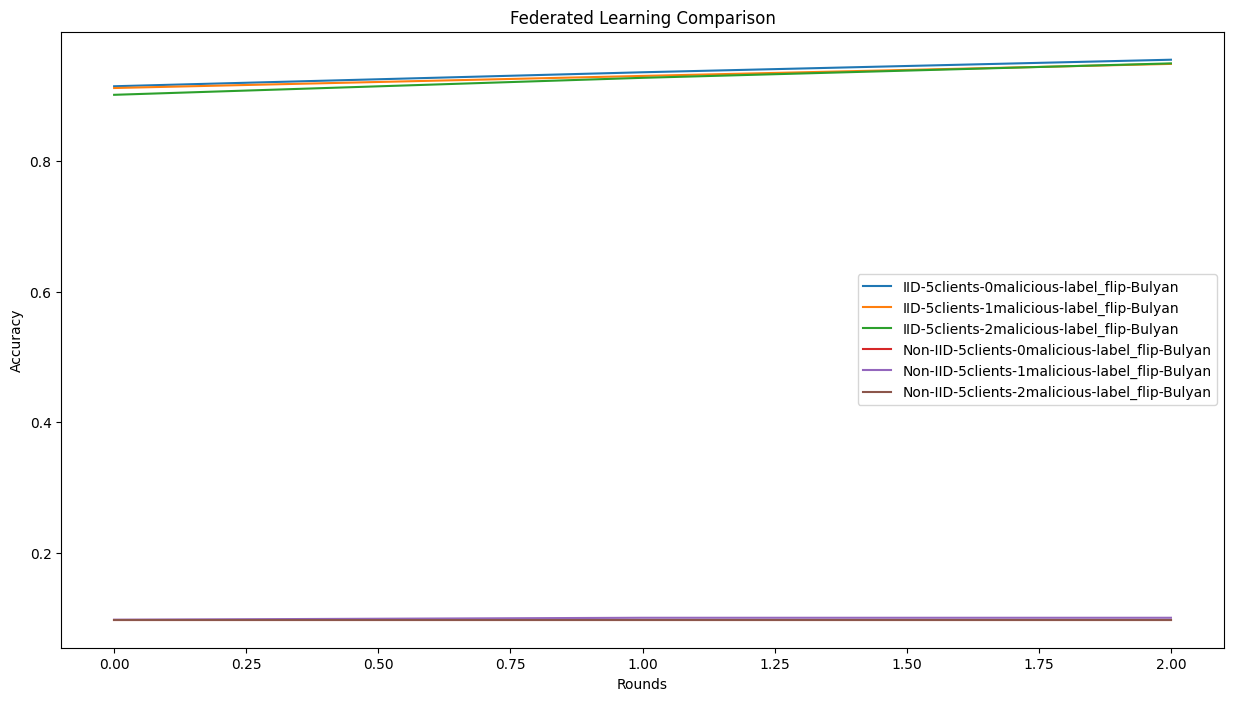

In [13]:

results = {}
# Main script
def main():
    num_clients_list = [5]
    num_malicious_list = [0,1,2]
    attack_types = ["label_flip"]
    #, "noise", "model_poisoning", "data_duplication", "random_data"]
    aggregation_methods = {
        #"Mean": mean_aggregation,
        #"Median": median_aggregation,
        # "Trimmed Mean": trimmed_mean_aggregation,
        # "FedAvg": federated_averaging,
        # "Krum": krum_aggregation,
         "Bulyan": bulyan_aggregation,
        # "DP": dp_aggregation
    }

    results = {}
    for iid in [True, False]:
        iid_label = "IID" if iid else "Non-IID"
        for num_clients in num_clients_list:
            for num_malicious in num_malicious_list:
                for attack in attack_types:
                    for method_name, aggregation_fn in aggregation_methods.items():
                        datasets = create_datasets(iid=iid, num_clients=num_clients)
                        accuracy = train_federated(create_cnn_model, datasets, aggregation_fn, attack, num_malicious)
                        key = f"{iid_label}-{num_clients}clients-{num_malicious}malicious-{attack}-{method_name}"
                        results[key] = accuracy
    # Plot results
    plt.figure(figsize=(15, 8))
    for key, accuracy in results.items():
        plt.plot(range(len(accuracy)), accuracy, label=key)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.title("Federated Learning Comparison")
    plt.show()
    return results

if __name__ == "__main__":
  resultfinal =  main()


In [14]:
import json
with open("results_label_flip_6.json", "w") as f:
    json.dump(resultfinal, f)

Round 1: Accuracy = 0.6795
Round 2: Accuracy = 0.6483
Round 3: Accuracy = 0.6043
Round 1: Accuracy = 0.5581
Round 2: Accuracy = 0.4817
Round 3: Accuracy = 0.3782
Round 1: Accuracy = 0.7512
Round 2: Accuracy = 0.6862
Round 3: Accuracy = 0.6437
Round 1: Accuracy = 0.1350
Round 2: Accuracy = 0.1002
Round 3: Accuracy = 0.1767
Round 1: Accuracy = 0.0999
Round 2: Accuracy = 0.1106
Round 3: Accuracy = 0.0952
Round 1: Accuracy = 0.1023
Round 2: Accuracy = 0.0740
Round 3: Accuracy = 0.0952


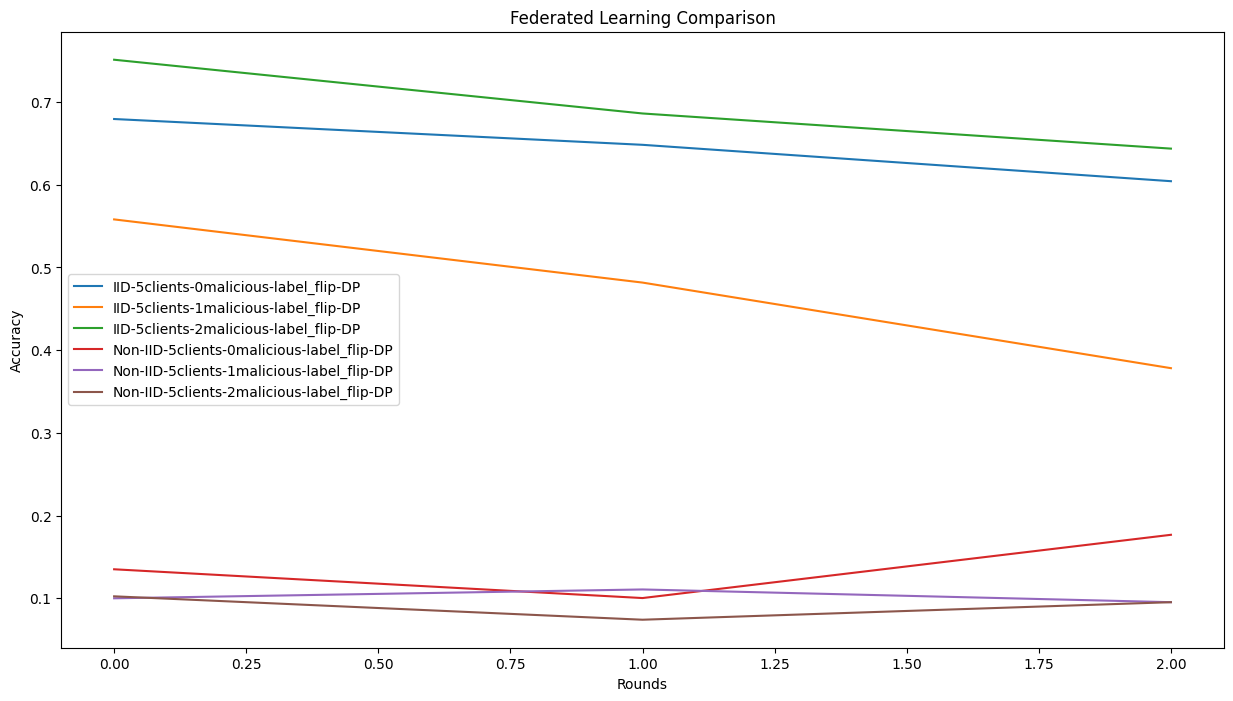

In [15]:

results = {}
# Main script
def main():
    num_clients_list = [5]
    num_malicious_list = [0,1,2]
    attack_types = ["label_flip"]
    #, "noise", "model_poisoning", "data_duplication", "random_data"]
    aggregation_methods = {
        #"Mean": mean_aggregation,
        #"Median": median_aggregation,
        # "Trimmed Mean": trimmed_mean_aggregation,
        # "FedAvg": federated_averaging,
        # "Krum": krum_aggregation,
        # "Bulyan": bulyan_aggregation,
         "DP": dp_aggregation
    }

    results = {}
    for iid in [True, False]:
        iid_label = "IID" if iid else "Non-IID"
        for num_clients in num_clients_list:
            for num_malicious in num_malicious_list:
                for attack in attack_types:
                    for method_name, aggregation_fn in aggregation_methods.items():
                        datasets = create_datasets(iid=iid, num_clients=num_clients)
                        accuracy = train_federated(create_cnn_model, datasets, aggregation_fn, attack, num_malicious)
                        key = f"{iid_label}-{num_clients}clients-{num_malicious}malicious-{attack}-{method_name}"
                        results[key] = accuracy

    # Plot results
    plt.figure(figsize=(15, 8))
    for key, accuracy in results.items():
        plt.plot(range(len(accuracy)), accuracy, label=key)
    plt.legend()
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.title("Federated Learning Comparison")
    plt.show()
    return results

if __name__ == "__main__":
  resultfinal =  main()


In [16]:
import json
with open("results_label_flip_7.json", "w") as f:
    json.dump(resultfinal, f)

In [17]:
import os
import json

# Directory containing the JSON files
directory = "/content"  # Replace with your directory path

# Dictionary to hold the merged data
merged_data = {}

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        filepath = os.path.join(directory, filename)
        with open(filepath, "r") as file:
            data = json.load(file)
            # Merge the content into the merged_data dictionary
            merged_data.update(data)

# Output file for the merged JSON
output_file = "merged_file.json"

# Write the merged data to a single JSON file
with open(output_file, "w") as outfile:
    json.dump(merged_data, outfile, indent=4)

print(f"Merged JSON files saved to {output_file}")


Merged JSON files saved to merged_file.json


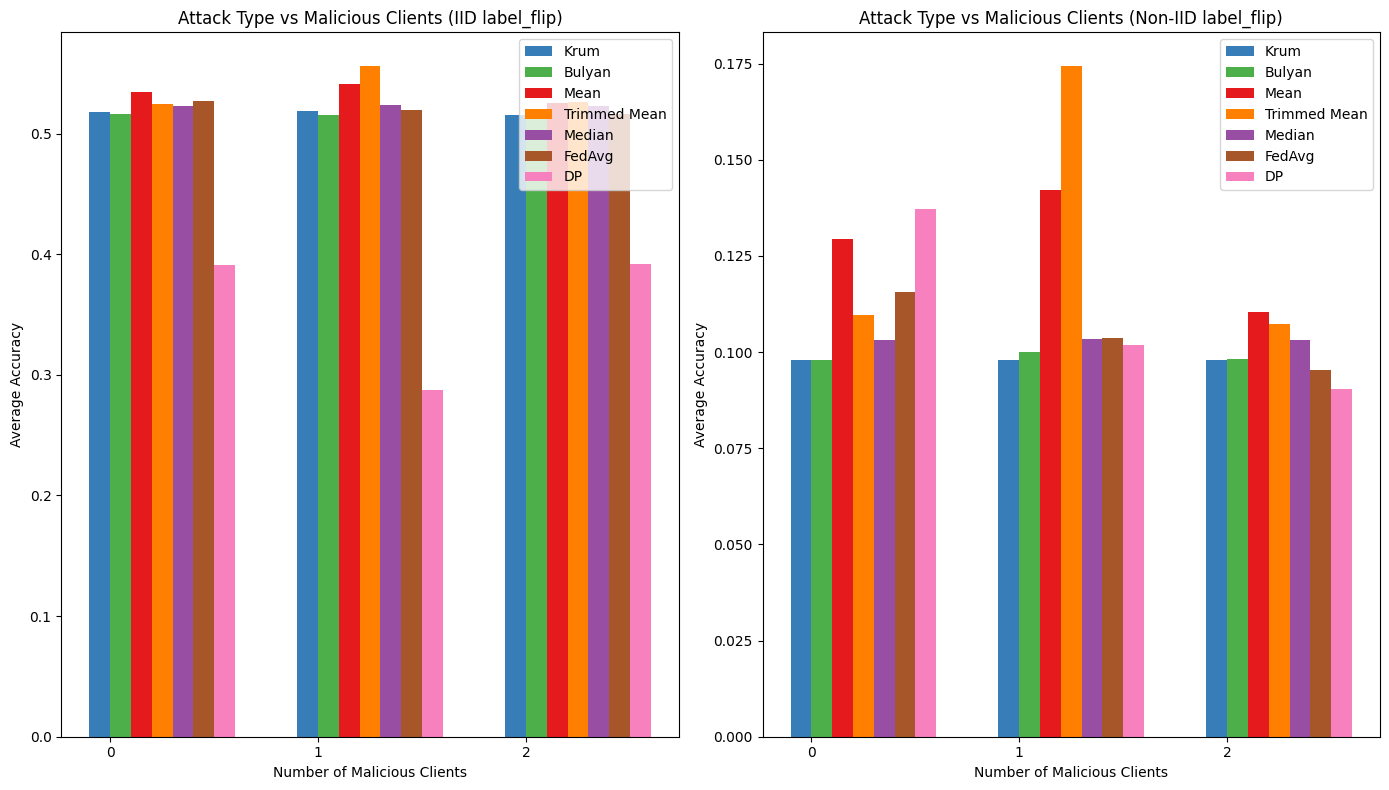

In [24]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

# Reading results from JSON file for plotting
results_file = "merged_file.json"  # Replace with your JSON file containing the results
with open(results_file, "r") as file:
    results = json.load(file)

# Aggregation Methods Across Malicious Clients (Line Chart for IID and Non-IID)
def plot_aggregation_vs_malicious_clients_iid_non_iid(results):
    methods = ["Krum", "Bulyan", "Mean", "Trimmed Mean", "Median", "FedAvg", "DP"]
    colors = [
        "blue",  # Krum
        "green",  # Bulyan
        "red",    # Mean
        "orange", # Trimmed Mean
        "purple", # Median
        "cyan",   # FedAvg
        "magenta" # DP
    ]

    scenarios = ["IID", "Non-IID"]

    plt.figure(figsize=(14, 8))

    for scenario_idx, scenario in enumerate(scenarios):
        plt.subplot(1, 2, scenario_idx + 1)
        added_to_legend = set()  # Track methods added to the legend

        for method, color in zip(methods, colors):
            malicious_counts = []
            avg_accuracies = []

            for key in results:
                if method in key and scenario in key:
                    malicious_count = int(key.split("-")[2][0])
                    malicious_counts.append(malicious_count)
                    avg_accuracies.append(np.mean(results[key]))

            if malicious_counts:  # Plot only if data exists for the method
                plt.plot(
                    malicious_counts,
                    avg_accuracies,
                    label=method if method not in added_to_legend else None,
                    color=color,
                    marker="o",
                )
                added_to_legend.add(method)

        plt.xlabel("Number of Malicious Clients")
        plt.ylabel("Average Accuracy")
        plt.title(f"Aggregation Methods vs. Malicious Clients ({scenario})")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Attack Type and Malicious Clients (Stacked Bar Chart for IID and Non-IID)
def plot_attack_vs_malicious_clients_iid_non_iid(results):
    attack_types = ["label_flip"]
    num_malicious = [0, 1, 2]
    methods = ["Krum", "Bulyan", "Mean", "Trimmed Mean", "Median", "FedAvg", "DP"]
    colors = [
        "#377eb8",  # Darkened pastel blue
        "#4daf4a",  # Darkened pastel green
        "#e41a1c",  # Darkened pastel red
        "#ff7f00",  # Darkened pastel orange
        "#984ea3",  # Darkened pastel purple
        "#a65628",  # Darkened pastel brown
        "#f781bf"   # Darkened pastel pink
    ]

    scenarios = ["IID", "Non-IID"]
    width = 0.1

    plt.figure(figsize=(14, 8))

    for scenario_idx, scenario in enumerate(scenarios):
        plt.subplot(1, 2, scenario_idx + 1)
        x = np.arange(len(num_malicious))

        for i, (method, color) in enumerate(zip(methods, colors)):
            values = []
            for n in num_malicious:
                values.append(
                    np.mean(
                        [
                            np.mean(results[key])
                            for key in results
                            if f"{n}malicious" in key and method in key and scenario in key
                        ]
                    )
                )
            plt.bar(
                x + i * width,
                values,
                width,
                label=method,
                color=color,
            )

        plt.xlabel("Number of Malicious Clients")
        plt.ylabel("Average Accuracy")
        plt.title(f"Attack Type vs Malicious Clients ({scenario} {attack_types[0]})")
        plt.xticks(x + width / 2, [str(n) for n in num_malicious])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the trends for both scenarios
#plot_aggregation_vs_malicious_clients_iid_non_iid(results)
plot_attack_vs_malicious_clients_iid_non_iid(results)
